In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import PIL.Image
%matplotlib inline
plt.style.use('fivethirtyeight')
from PIL import Image
import keras
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from google.colab import drive
import os
import gc
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import History
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/dataset_processed/Foriginal")
classes = {'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3} #defines a dictionar called classes, where each key-value pair in the dictionary represents a class label and its corresponding numerical value.

In [ ]:
#the two syntaxes can be joined is one command image_count = len(list(data_dir.glob('*/*.jpg')))
image_files = list(data_dir.glob("**/*.jpg"))
# Count the number of image files found
num_images = len(image_files)

print("Number of images found:", num_images)

Number of images found: 4000


In [ ]:
import cv2 # library in python for data processing
#By assigning an empty list to the variable X, you are creating an empty container that can be used to store and manipulate data.
#Later in your code, you can append or extend this list with elements, remove elements, access specific elements, or perform various operations on the list.

X = [] #initializes a variable named X as an empty list.
Y = [] #initializes a variable named Y as an empty list.
for cls in classes :
    folder_path = os.path.join(data_dir, cls)  # Path to the class subfolder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)  # Path to the image file
        img = cv2.imread(img_path,0)  # Read the image using OpenCV/ 0: is for converting the colored image to gary-scale image
        if img is not None:
           img = cv2.resize(img, (224, 224))
           X.append(img) #a list where each item represents an image. Each image will be in the form of a NumPy array => (num_images, 200, 200). will be a list of NumPy arrays representing the resized images
           Y.append(classes[cls]) #will be a list of labels associated with each image.(same length os X)


In [ ]:
np.unique(Y)#It is used to find the unique elements in an array Y and returns them in sorted order.

array([0, 1, 2, 3])

In [ ]:
pd.Series(Y).value_counts()#It counts the occurrence of each unique value in a series Y and returns the result as a new series, where the unique values are the index and the counts are the values.

0    1000
1    1000
2    1000
3    1000
dtype: int64

In [ ]:
num_images = len(X)
print("Number of images found:", num_images)

Number of images found: 4000


In [ ]:
#convert a list X,Y into a NumPy array(Tensorflow library expect the input data to be in NumPy arrays or errors will happens)
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) # reshapes the array X by adding a new dimension of size 1 at the end (it's essential when working with convolutional neural networks (CNNs) where the input data is expected to have a specific shape, including a channel dimension).
print("X.shape[0]:", X.shape[0])
print("X.shape[1]:", X.shape[1])
print("X.shape[2]:", X.shape[2])

X.shape[0]: 4000
X.shape[1]: 224
X.shape[2]: 224


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=10, test_size=.20) #same train-test split every time i run the code
xtrain = xtrain / 255.0
xtest = xtest / 255.0
print(xtrain.shape, xtest.shape)

(3200, 224, 224, 1) (800, 224, 224, 1)


In [ ]:
pd.Series(ytest).value_counts()#to make sure the splitting is performed on the 4 classes

1    222
3    200
0    194
2    184
dtype: int64

In [ ]:
#to det the type of class in object
print(type(xtrain))
print(type(xtest))
print(type(ytrain))
print(type(ytest))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
#to disply the datatype of variables
print(ytrain.dtype)
print(ytest.dtype)
print(xtrain.dtype)
print(xtest.dtype)

int64
int64
float64
float64


In [ ]:
xtrain = xtrain.astype(int)
xtest = xtest.astype(int)
print(xtrain.dtype)
print(xtest.dtype)

int64
int64


In [ ]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
augmented_data = datagen.flow(xtrain, ytrain, batch_size=32)
batch_size=32
num_augmented_images = len(xtrain) // batch_size * batch_size
print("Number of augmented images:", num_augmented_images)
datagen.fit(xtrain)

Number of augmented images: 3200


In [ ]:
rotation_range = 20  # Range of rotation in degrees
width_shift_range = 0.2  # Range of horizontal shift as a fraction of total width
height_shift_range = 0.2  # Range of vertical shift as a fraction of total height
shear_range = 0.2  # Range of shear transformation
zoom_range = 0.2  # Range of zoom
num_samples = xtrain.shape[0]  # Number of original samples
augmentation_factor = (1 + rotation_range/20) * (1 + width_shift_range/0.2) * (1 + height_shift_range/0.2) * (1 + shear_range/0.2) * (1 + zoom_range/0.2)  * 2  # Assuming both horizontal_flip and vertical_flip are True
estimated_count = int(num_samples * augmentation_factor)

print("Estimated count of augmented images:", estimated_count)

Estimated count of augmented images: 204800


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())


model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(4, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32), validation_data=(xtest, ytest), epochs=50)

Epoch 1/50
100/100 [==============================] - 30s 157ms/step - loss: 1.3869 - accuracy: 0.2453 - val_loss: 1.3871 - val_accuracy: 0.2500
Epoch 2/50
100/100 [==============================] - 15s 149ms/step - loss: 1.3866 - accuracy: 0.2453 - val_loss: 1.3865 - val_accuracy: 0.2300
Epoch 3/50
100/100 [==============================] - 15s 152ms/step - loss: 1.3864 - accuracy: 0.2550 - val_loss: 1.3875 - val_accuracy: 0.2300
Epoch 4/50
100/100 [==============================] - 15s 148ms/step - loss: 1.3867 - accuracy: 0.2584 - val_loss: 1.3874 - val_accuracy: 0.2300
Epoch 5/50
100/100 [==============================] - 15s 154ms/step - loss: 1.3866 - accuracy: 0.2594 - val_loss: 1.3880 - val_accuracy: 0.2300
Epoch 6/50
100/100 [==============================] - 17s 171ms/step - loss: 1.3823 - accuracy: 0.2675 - val_loss: 1.3865 - val_accuracy: 0.2300
Epoch 7/50
100/100 [==============================] - 15s 152ms/step - loss: 1.3816 - accuracy: 0.2859 - val_loss: 1.3872 - val_ac

In [ ]:
pred=model.predict(xtest)#returns a NumPy array of predicted values of xtrain dataset(each row is a sample, each column is a class proba)
predict = np.argmax(pred, axis=1) #to obtain the class label associated with the highest predicted probability for each image.
print(predict)
num_classes = len(np.unique(ytrain))
pred_onehot = np.eye(num_classes)[predict]


25/25 [==============================] - 1s 16ms/step
[2 2 1 2 0 1 2 0 0 1 1 2 0 1 0 3 1 1 3 0 3 2 1 0 3 2 2 3 1 1 1 3 3 1 3 0 0
 0 3 3 3 1 3 2 2 0 3 2 1 1 3 1 0 3 0 3 3 0 1 2 0 1 3 1 3 3 0 1 2 2 1 1 2 3
 2 0 1 3 3 1 3 0 1 3 0 3 0 0 1 1 0 3 3 0 3 1 1 1 1 0 0 3 1 1 0 0 2 3 0 3 1
 3 0 1 3 3 1 3 2 2 1 3 2 1 3 2 1 0 2 0 1 3 3 2 2 2 0 1 3 1 1 1 1 1 2 3 2 2
 1 0 0 1 2 0 1 3 1 3 1 3 0 3 0 1 2 2 1 2 1 3 3 1 3 2 0 0 3 0 0 3 2 2 1 2 3
 3 0 0 0 0 3 1 1 3 0 1 2 1 0 1 1 1 0 0 1 1 1 0 1 3 2 3 2 3 2 3 2 2 3 2 1 2
 3 3 3 0 2 1 0 3 1 3 1 1 3 2 2 2 3 1 3 1 2 2 3 1 2 3 1 1 0 1 1 0 3 3 3 0 1
 0 3 1 2 0 0 1 2 1 1 3 1 3 1 0 0 2 3 3 1 2 2 3 1 2 1 0 3 3 3 0 0 2 3 0 2 1
 0 2 0 0 2 2 3 1 0 1 3 3 2 2 1 0 2 3 1 1 2 1 2 1 1 1 1 1 1 3 2 0 3 2 0 3 0
 2 2 1 0 3 0 1 2 2 3 2 1 2 3 0 2 2 3 2 3 0 0 0 0 3 0 1 0 2 1 0 2 3 3 1 2 0
 3 3 1 3 3 2 1 3 3 2 0 2 1 3 1 2 2 1 3 0 2 3 0 1 3 1 0 1 3 1 0 1 1 1 1 2 2
 2 3 1 3 1 0 2 3 1 1 0 1 3 0 0 1 0 3 0 3 2 3 0 1 1 2 0 2 0 1 3 1 3 2 3 0 3
 0 3 1 3 1 0 1 0 1 3 3 2 1 0 3 2 0 0 0 0 1 3 0

In [ ]:
print(ytest)

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest, predict)
cm_df = pd.DataFrame(cm,
                     index = ['Benign','Early','Pre','Pro'],
                     columns = ['Benign','Early','Pre','Pro'])
print(cm_df)

        Benign  Early  Pre  Pro
Benign     184     10    0    0
Early        8    213    1    0
Pre          7      8  168    1
Pro          1      3    0  196


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(ytest, predict)
print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       194
           1       0.91      0.96      0.93       222
           2       0.99      0.91      0.95       184
           3       0.99      0.98      0.99       200

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'Benign'),
  Text(1.5, 0, 'Early'),
  Text(2.5, 0, 'Pre'),
  Text(3.5, 0, 'Pro')])

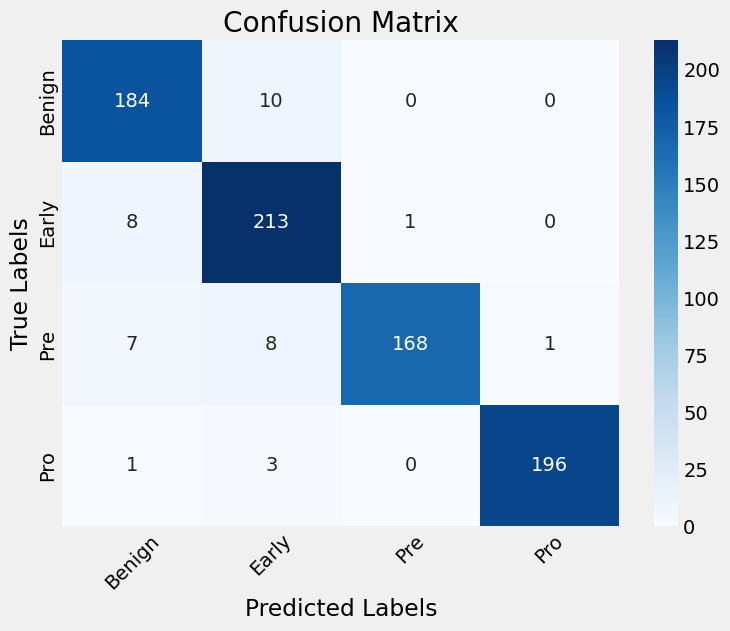

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a heatmap of the confusion matrix
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Rotate tick labels if needed
plt.xticks(rotation=45)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, predict)

0.95125

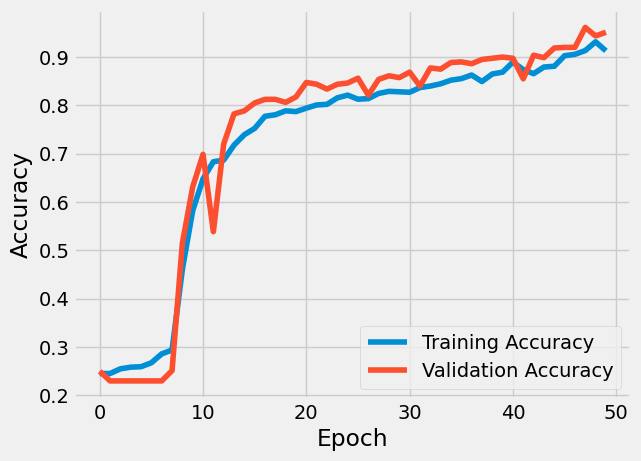

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

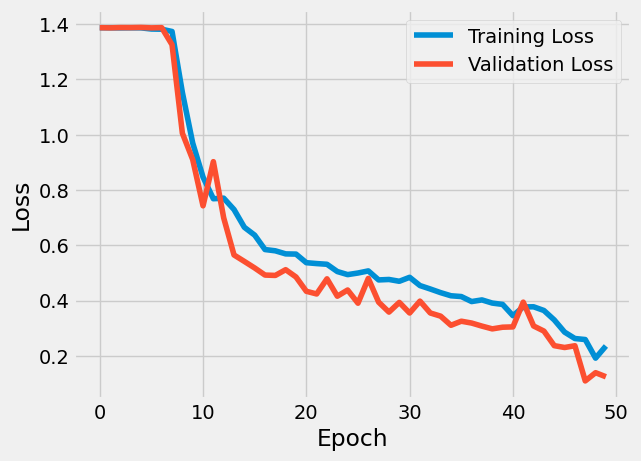

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(xtest, ytest)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
loss, accuracy = model.evaluate(xtrain, ytrain)
print("train Loss:", loss)
print("train Accuracy:", accuracy)

25/25 [==============================] - 0s 18ms/step - loss: 0.1253 - accuracy: 0.9513
Test Loss: 0.1252901703119278
Test Accuracy: 0.9512500166893005
100/100 [==============================] - 1s 15ms/step - loss: 0.1181 - accuracy: 0.9522
train Loss: 0.11814838647842407
train Accuracy: 0.9521874785423279


In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data_dir1 = pathlib.Path("/content/drive/MyDrive/dataset_processed/Unseen_data")
classes = {'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}
UX = []
UY = []
for cls in classes:
    folder_path = os.path.join(data_dir1, cls)  # Path to the class subfolder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)  # Path to the image file
        img = cv2.imread(img_path,0)  # Read the image using OpenCV
        if img is not None:
           img = cv2.resize(img, (224, 224))
           UX.append(img) #a list where each item represents an image. Each image will be in the form of a NumPy array => (num_images, 200, 200). will be a list of NumPy arrays representing the resized images
           UY.append(classes[cls]) #will be a list of labels associated with each image.(same length os X)

In [ ]:
num_images1 = len(UX)

print("Number of images found:", num_images1)

Number of images found: 400


In [ ]:
np.unique(UY)
pd.Series(UY).value_counts()

0    100
1    100
2    100
3    100
dtype: int64

In [ ]:
UX = np.array(UX)
UY = np.array(UY)
UX = UX.reshape(UX.shape[0], UX.shape[1], UX.shape[2], 1)
print("UX.shape[0]:", UX.shape[0])
print("UX.shape[1]:", UX.shape[1])
print("UX.shape[2]:", UX.shape[2])

UX.shape[0]: 400
UX.shape[1]: 224
UX.shape[2]: 224


In [ ]:
uxtrain, uxtest, uytrain, uytest = train_test_split(UX, UY, random_state=10, test_size=.01) #same train-test split every time i run the code
uxtrain = uxtrain / 255.0
uxtest = uxtest / 255.0
print(uxtrain.shape, uxtest.shape)

(396, 224, 224, 1) (4, 224, 224, 1)


In [ ]:
pd.Series(uytrain).value_counts()

0    100
2     99
1     99
3     98
dtype: int64

In [ ]:
upred= model.predict(uxtrain)#returns a NumPy array of predicted values of xtrain dataset(each row is a sample, each column is a class proba)
upredict = np.argmax(upred, axis=1) #to obtain the class label associated with the highest predicted probability for each image.
print(upredict)
unum_classes = len(np.unique(uytrain))
upred_onehot = np.eye(num_classes)[upredict]

13/13 [==============================] - 1s 43ms/step
[0 3 0 2 1 1 1 1 3 2 0 2 0 0 0 3 0 1 3 2 3 1 2 2 3 3 0 0 1 0 3 1 3 3 1 1 1
 3 0 0 2 1 2 2 3 0 0 2 3 0 3 2 1 0 1 2 0 1 3 2 0 0 1 2 0 1 1 3 0 1 0 3 1 1
 0 1 0 3 1 1 1 1 1 1 1 1 3 0 1 2 0 0 3 0 1 0 0 0 3 3 2 3 1 0 2 1 0 0 1 0 3
 0 2 0 0 1 3 0 0 3 1 3 3 0 1 1 1 2 1 0 1 2 3 0 2 1 3 1 3 3 1 3 0 3 0 2 2 1
 0 1 3 3 2 1 3 0 0 0 1 1 1 1 0 2 0 1 1 1 3 1 1 0 0 1 1 1 1 1 3 0 1 0 0 2 3
 3 0 3 2 3 0 1 2 1 0 0 3 1 3 3 2 1 1 0 2 1 0 2 1 3 3 1 0 3 3 3 3 1 1 0 1 1
 3 1 1 1 3 1 2 1 3 3 0 3 0 0 1 0 0 0 3 1 3 1 1 3 1 0 1 2 1 2 3 0 2 0 1 3 3
 1 3 2 2 1 2 1 1 3 0 3 3 3 0 0 0 0 0 2 0 3 1 3 1 2 3 3 0 1 2 2 3 0 1 1 3 3
 0 0 3 0 3 0 0 1 1 0 0 3 1 3 2 0 2 0 1 3 1 2 1 0 1 2 0 1 1 1 1 0 1 3 3 0 1
 0 0 2 2 0 1 1 3 0 1 3 3 2 0 0 2 0 3 0 0 0 2 3 0 3 1 0 1 1 3 3 1 1 0 0 3 1
 1 3 2 0 0 1 3 3 0 2 3 1 3 0 1 0 0 3 2 1 1 3 3 0 1 2]


In [ ]:
print(uytrain)

[0 3 0 2 1 1 1 1 3 2 0 2 0 0 0 3 0 1 3 2 3 1 2 2 3 3 0 0 1 0 3 1 3 2 1 1 1
 3 0 0 2 1 2 2 3 0 0 2 3 0 3 2 2 0 2 2 0 2 3 2 2 2 1 2 0 1 1 3 0 1 0 3 1 1
 0 0 3 3 1 1 1 1 1 1 1 1 3 0 1 2 0 0 3 0 1 0 0 0 3 3 2 3 1 0 2 1 0 2 1 0 3
 0 2 2 0 1 3 0 2 2 1 3 3 0 1 2 1 2 1 2 1 2 3 0 2 2 3 2 3 2 1 3 0 3 0 2 2 1
 0 1 3 3 2 1 3 2 0 0 2 1 1 1 0 2 0 1 0 2 3 2 1 0 3 1 2 1 1 1 3 0 1 0 0 2 3
 3 0 3 2 3 0 1 2 1 0 1 3 2 3 3 2 1 1 0 2 1 0 2 1 3 3 1 0 3 3 3 3 2 1 0 1 2
 3 1 1 1 3 1 2 1 3 3 0 3 0 0 1 0 0 0 3 2 3 1 1 3 1 2 2 2 1 2 3 0 2 2 1 3 3
 1 3 2 2 1 2 2 1 3 0 3 3 3 0 0 0 0 0 2 2 3 1 3 1 2 3 3 0 0 2 2 3 0 1 2 3 3
 0 0 3 2 2 0 0 1 1 2 0 3 2 3 2 0 2 0 1 3 2 2 1 0 1 2 0 2 1 1 2 2 1 3 3 0 1
 0 2 2 2 2 1 1 3 0 1 3 3 2 0 3 2 0 3 0 0 2 2 3 0 3 1 0 1 2 3 3 1 2 0 0 3 1
 1 3 2 0 0 1 3 3 0 2 3 0 3 0 2 0 0 3 2 1 1 3 3 0 1 2]


In [ ]:
from sklearn.metrics import confusion_matrix
cm1=confusion_matrix(uytrain, upredict)
cm_df1 = pd.DataFrame(cm1,
                     index = ['Benign','Early','Pre','Pro'],
                     columns = ['Benign','Early','Pre','Pro'])
print(cm_df1)

        Benign  Early  Pre  Pro
Benign      96      4    0    0
Early        1     98    0    0
Pre         16     24   55    4
Pro          3      0    0   95


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'Benign'),
  Text(1.5, 0, 'Early'),
  Text(2.5, 0, 'Pre'),
  Text(3.5, 0, 'Pro')])

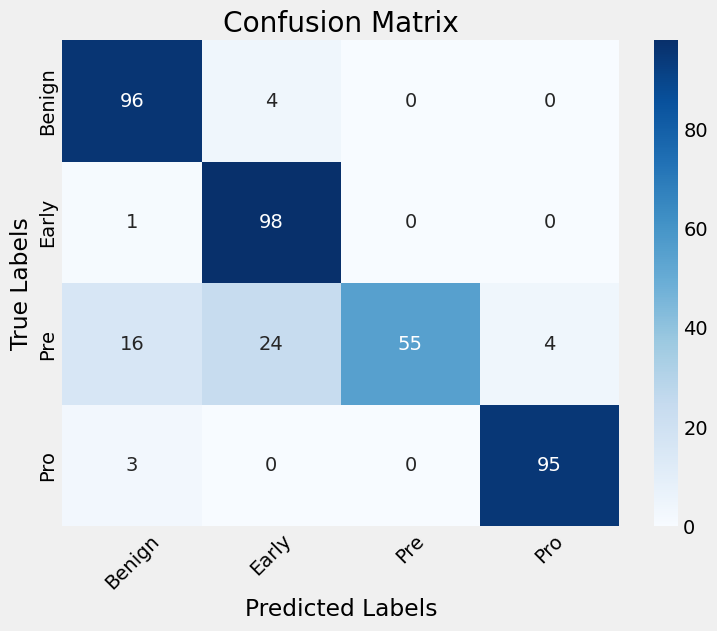

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a heatmap of the confusion matrix
sns.heatmap(cm_df1, annot=True, fmt='d', cmap='Blues', ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Rotate tick labels if needed
plt.xticks(rotation=45)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(uytrain, upredict)

0.8686868686868687